# Анализ поведения клиентов сети фитнес-центров

**Описание проекта**

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Цель — провести анализ клиентских анкет и подготовить план действий по удержанию клиентов.

Задачи:
1. выделить целевые группы клиентов;
2. предложить меры по снижению оттока;
3. определить другие особенности взаимодействия с клиентами.

**Описание данных**

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

Данные клиента за предыдущий до проверки факта оттока месяц:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

## Загрузка и предобработка данных

Загрузим данные, оптимизируем для анализа. Убедимся, что тип данных в каждой колонке — правильный, а также отсутствуют пропущенные значения и дубликаты.

In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as st
import math as mth
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from textwrap import fill
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

pd.set_option('display.max_colwidth', None)

In [2]:
def read_file(file_name):
    path1 = os.path.join('/datasets', file_name)
    path2 = os.path.join(file_name)
    if os.path.exists(path1):
        df = pd.read_csv(path1)
        return df
    elif os.path.exists(path2):
        df = pd.read_csv(path2,)
        return df
    else:
        print('File is not found')

In [3]:
df = read_file('/datasets/gym_churn.csv')

In [4]:
def initial_analysis(df):
    df.info(),
    display(df.head(10)),
    display(df.describe())

In [5]:
initial_analysis(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [6]:
# приводим названия колонок к нижнему регистру
df.columns = df.columns.str.lower()

In [7]:
# проверяем наличие дубликатов
df.duplicated().sum()

0

**Выводы**

Всего 13 колонок, 4000 строк. Тип данных во всех колонках числовой. Дубликаты и пропущенные значения отсутствуют. Колонки gender, Near_Location, Partner, Promo_friends, Phone,	Group_visits и Churn имеют только два класса - 0 и 1. 

- Согласно данным колонки Age, средний возраст клиента составляет 29 лет, стандартное отклонение 3.26. 
- Суммарная выручка от других услуг фитнес-центра (Avg_additional_charges_total) в среднем составляет 146, стандартное отклонение 96. 
- Срок до окончания текущего действующего абонемента (Month_to_end_contract) в среднем 4 месяца, стандартное отклонение 4. 
- Время с момента первого обращения в фитнес-центр в среднем 3.7 месяца, стандартное отклонение 3.7. 
- Средняя частота посещений в неделю за все время (Avg_class_frequency_total) - 1.87, стандартное отклонение 0.97. 
- Средняя частота посещений в неделю за предыдущий месяц (Avg_class_frequency_current_month) - 1.77, стандартное отклонение 1.05.

## Исследовательский анализ данных

In [8]:
# Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Значения в колонках с полом и телефоном одинаковые, можно предположить, что эти признаки не оказывают влияния на уход клиентов.

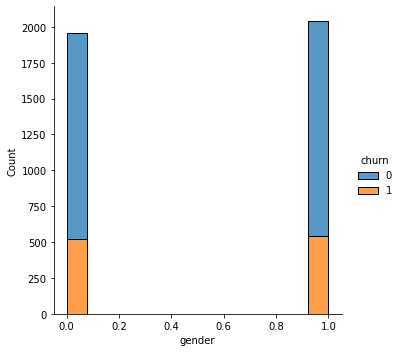

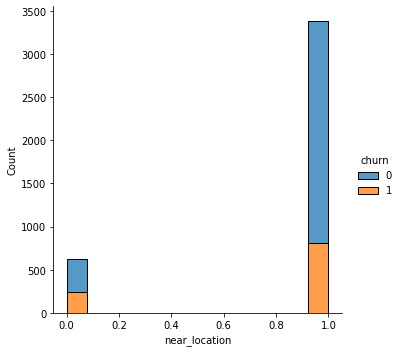

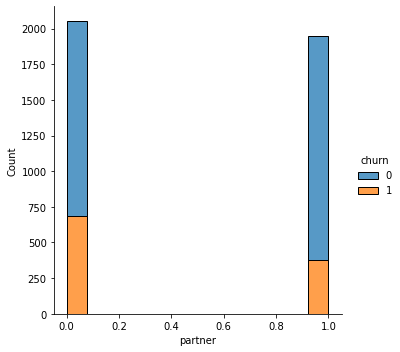

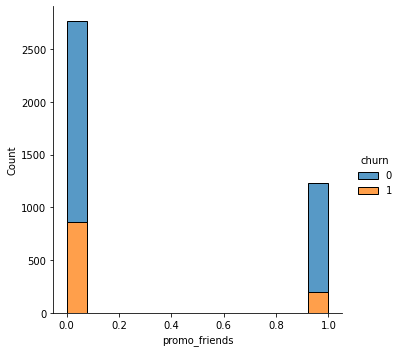

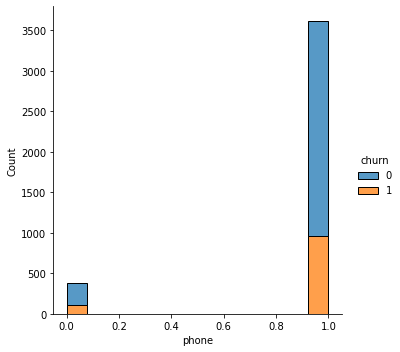

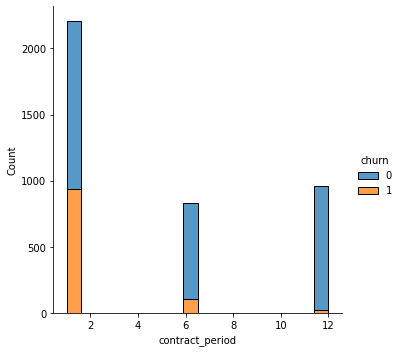

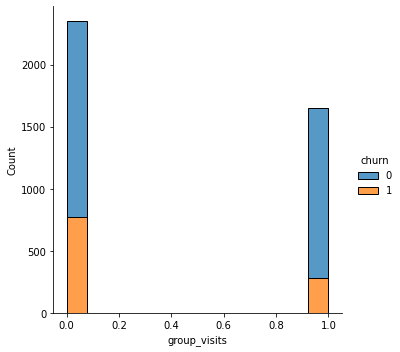

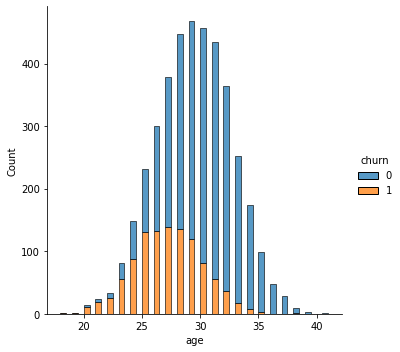

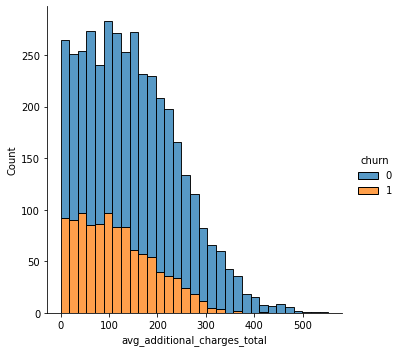

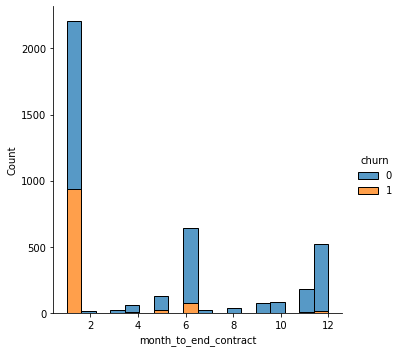

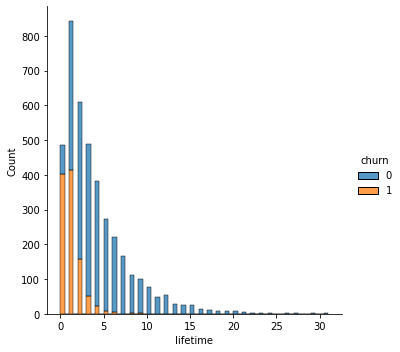

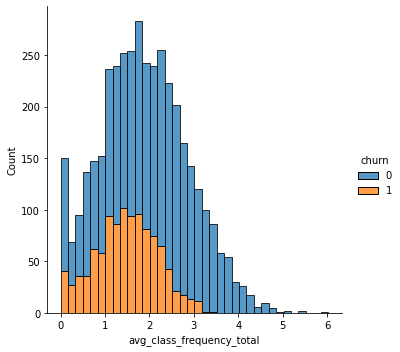

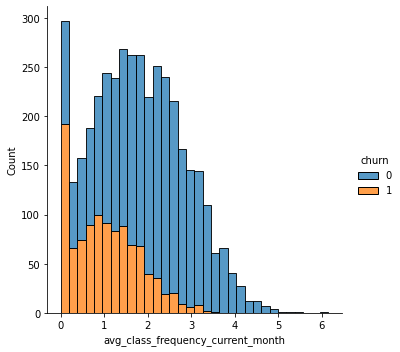

In [9]:
# построим гистограммы распределения признаков
for col in df.drop('churn', axis = 1).columns:
    sns.displot(df, x=col, hue='churn', multiple='stack')
    plt.show()

- Распределение по половому признаку примерно одинаковое. 
- Большая часть клиентов проживает или работает в районе, где находится фитнес-центр. 
- Доля клиентов от компаний партнеров среди ушедших ниже, чем среди оставшихся. 
- Клиенты пришедшие по промокоду от друга меньше уходят.
- Почти все клиенты оставляют номер телефона. 
- Самая популярная длительность абонемента - 1 месяц, и это же самая частая категория из которой уходят клиенты. 
- Клиенты с длительными абонементами уходят значительно реже. 
- Наиболее высокая доля ушедших в возрастных группах до 26 лет. 
- Средние дополнительные траты уходящих редко превышают 300. 
- Чаще всего уходят клиенты с одним оставшимся месяцем по абонементу. 
- Чем дольше клиент ходит в фитнес центр, тем меньше вероятность что он уйдет. Доля ушедших среди ходивших больше 5 месяцев минимальна.
- Средняя посещаемость в текущем месяце близка к нулю у большого числа ушедших клиентов, однако если смотреть за все время, их число снижается. 

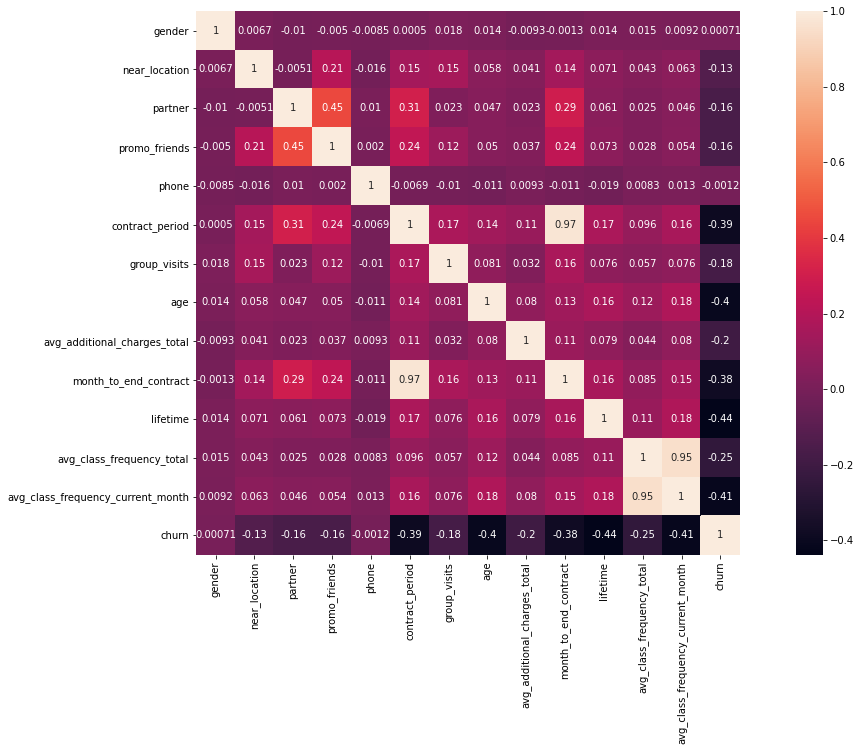

In [10]:
# построим матрицу корелляции и тепловую карту
cm = df.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, square=True)
plt.show()

Наблюдается высокая корелляция между двумя парами признаков: Contract_period и Month_to_end_contract; Avg_class_frequency_current_month и Avg_class_frequency_total. Это объясняется схожестью признаков, в первой паре чем больше период действия абонемента, тем больше месяцев остается до конца, во второй паре чем выше посещаемость за всё время, тем выше за последний месяц - посещаемость клиентов стабильна.

По отношению к целевой переменной, наименьшую корелляцию имеют признаки gender и phone. Наибольшей корелляцией обладают lifetime, Avg_class_frequency_current_month, age, contract_period и Month_to_end_contract.

In [11]:
# оценим баланс классов
df['churn'].value_counts(normalize=True)

0    0.73475
1    0.26525
Name: churn, dtype: float64

**Выводы**

- Признаки gender и phone предположительно слабо влияют на целевую переменную.

- Наибольшее влияние на целевую переменную по корелляции оказывают признаки lifetime, Avg_class_frequency_current_month, age, contract_period и Month_to_end_contract.

- Обнаружена высокая корелляция между Contract_period и Month_to_end_contract; Avg_class_frequency_current_month и Avg_class_frequency_total. Необходимо учесть это при построении линейной модели.

## Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

In [12]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y), исключаем лишние признаки
X = df.drop(['churn'], axis = 1)
y = df['churn']

# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
# зададим алгоритм для нашей модели
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=0)

# обучим модель
model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test)

# выведем все изученные метрики
display('Метрики для логистической регрессии') 
display('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
display('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
display('Recall: {:.2f}'.format(recall_score(y_test, predictions)))

'Метрики для логистической регрессии'

'Accuracy: 0.90'

'Precision: 0.74'

'Recall: 0.90'

In [14]:
# зададим алгоритм для новой модели на основе алгоритма решающего дерева
tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=0)

tree_model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
tree_predictions = tree_model.predict(X_test)

# выведем все изученные метрики
display('Метрики для дерева принятия решения')
display('Accuracy: {:.2f}'.format(accuracy_score(y_test, tree_predictions)))
display('Precision: {:.2f}'.format(precision_score(y_test, tree_predictions)))
display('Recall: {:.2f}'.format(recall_score(y_test, tree_predictions)))

'Метрики для дерева принятия решения'

'Accuracy: 0.90'

'Precision: 0.79'

'Recall: 0.80'

In [15]:
# оценим важность признаков в модели
importances = pd.DataFrame(
    {'feature':X.columns,'importance':np.round(tree_model.feature_importances_,3)}
)

importances = importances.sort_values('importance',ascending=False)
importances

,feature,importance
10,lifetime,0.428
12,avg_class_frequency_current_month,0.161
11,avg_class_frequency_total,0.118
9,month_to_end_contract,0.116
8,avg_additional_charges_total,0.069
7,age,0.064
4,phone,0.010
6,group_visits,0.010
3,promo_friends,0.008
2,partner,0.007


**Выводы**

1. По доле правильных ответов модели одинаковы, в метрике Precision лучше себя показало дерево принятия решений, по метрике Recall лучше логистическая регрессия.

2. В нашем исследовании важно правильно оценить долю правильных ответов только среди целевого класса - ушедших клиентов (метрика Precision). Поэтому модель дерева принятия решений выглядит предпочтительнее.

3. Оценка важности признаков в модели дерева принятия решений показала наиболее важные признаки:
  - lifetime;
  - avg_class_frequency_current_month;
  - avg_class_frequency_total;
  - month_to_end_contract;
  - avg_additional_charges_total;
  - age.

## Кластеризация клиентов

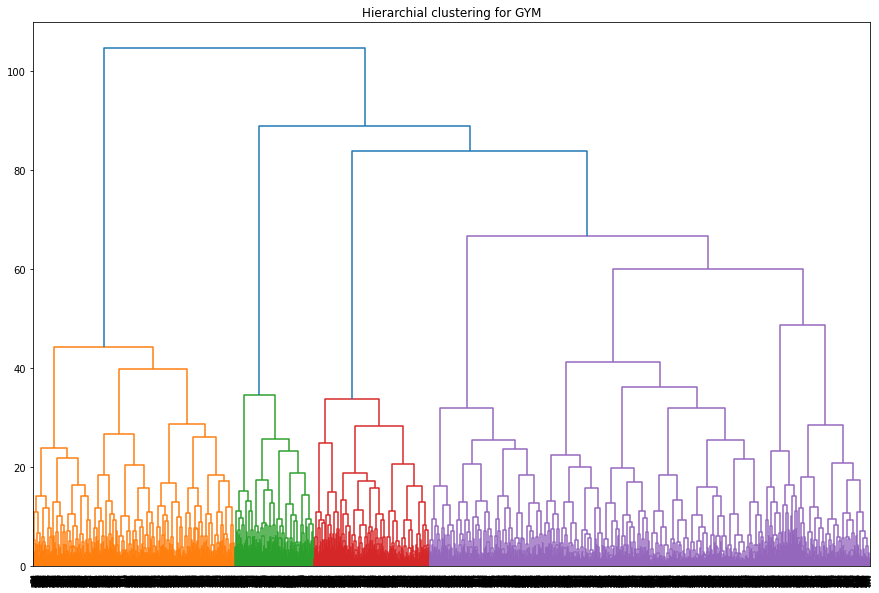

In [16]:
# стандартизируем признаки
X = df.drop('churn', axis = 1)

sc = StandardScaler()
X_sc = sc.fit_transform(X)

# строим матрицу расстояний 
linked = linkage(X_sc, method = 'ward') 

# строим дендрограмму 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

Оптимальное число классов согласно дендрограмме - 4.

In [17]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

In [18]:
# выводим статистику по средним значениям наших признаков по кластеру
display(df.groupby('cluster_km').mean().sort_values(by='churn'))

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263


In [19]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


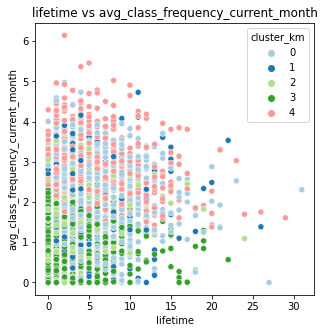

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


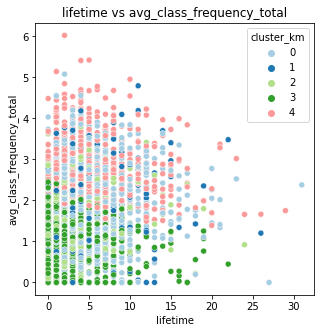

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


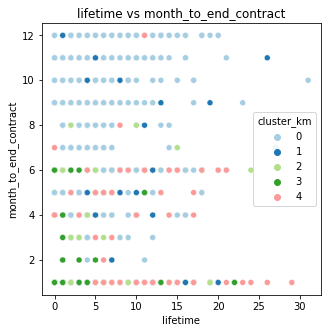

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


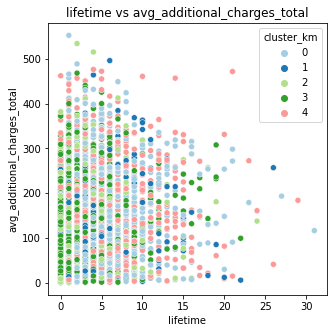

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


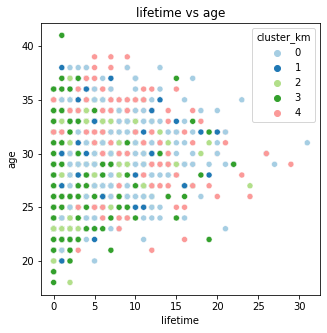

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


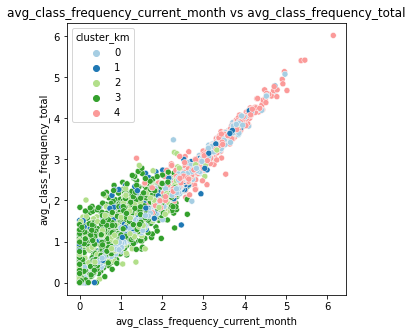

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


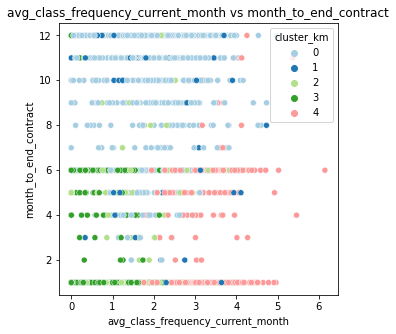

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


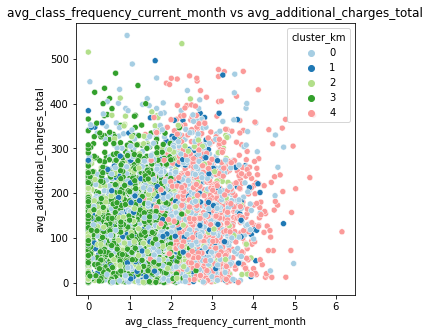

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


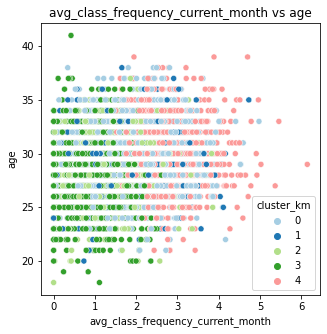

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


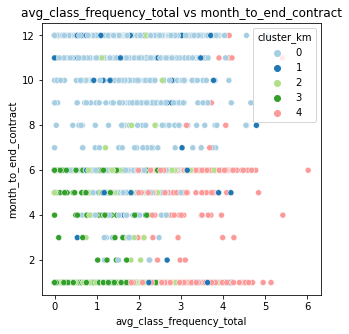

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


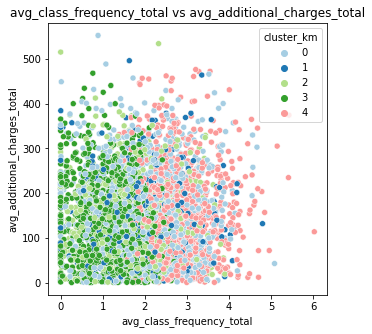

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


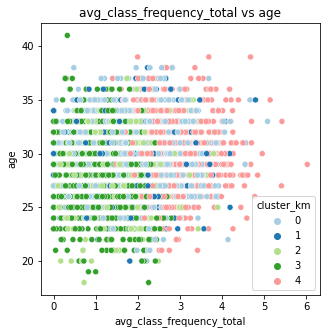

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


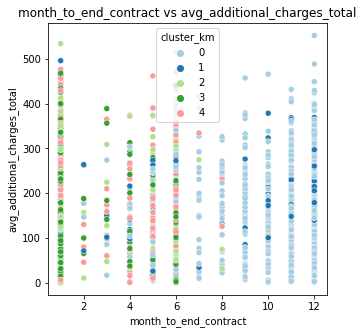

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


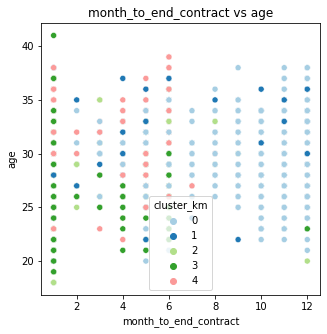

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


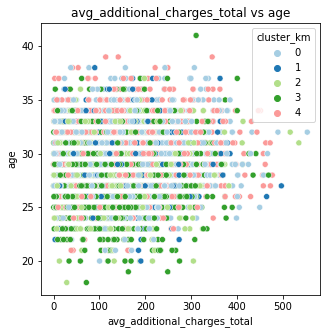

In [20]:
# создадим список с основными признаками, влияющими на модель
main_features = [
    'lifetime',
    'avg_class_frequency_current_month',
    'avg_class_frequency_total',
    'month_to_end_contract',
    'avg_additional_charges_total',
    'age'
]

# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(main_features, 2))
for pair in col_pairs:
    show_clusters_on_plot(df, pair[0], pair[1], 'cluster_km')

**Выводы**

- Сортировка кластеров по среднему значению оттока позволяет выделить кластеры склонные к оттоку (номера 1, 2, 3) и надежные кластеры (номера 0, 4).

- Для надежных кластеров характерны высокие средние значения большинства признаков.

## Общий вывод

Проведен анализ поведения клиентов сети фитнес-центров. Выделены основные признаки, наиболее сильно влияющие на отток. Построена модель прогнозирования вероятности оттока каждого клиента. Проведена кластеризация, клиенты разделены на 5 кластеров.
Выделены две основные группы клиентов.

1. Наибольшее влияние на целевую переменную оказывают признаки: 
 - время с момента первого обращения в фитнес-центр, 
 - средняя частота посещений в неделю за предыдущий месяц, 
 - средняя частота посещений в неделю за все время, 
 - срок до окончания текущего действующего абонемента,
 - средние дополнительные траты,
 - возраст. 


2. Проведена оценка двух моделей бинарной классификации клиентов: логистической регрессии и дерева принятия решений. По метрикам лучше себя показало дерево принятия решений.


3. Кластеризация на 5 кластеров позволила выделить 3 кластера склонных к оттоку и 2 надежных кластера. Для надежных кластеров характерны высокие средние значения большинства признаков.

Сформулируем рекомендации по повышению качества работы с клиентами:

1. Стоит повышать лояльность клиентов со следующими признаками:
  - возраст младше 26 лет;
  - с месячными абонементами;
  - со средними дополнительными тратами менее 300;
  - с низкой средней посещаемостью в текущем месяце;
  - недавно впервые пришедших в фитнес-центр.
  
  
2. Снизить отток можно с помощью:
  - скидок на длительные абонементы (более месяца);
  - стимулировать клиентов чаще посещать фитнес-центр (повышать среднюю посещаемость);
  - стимулировать новичков продолжать посещения после первого месяца (давать скидку на второй месяц абонемента)


3. Меры по привлечению новых клиентов:
  - продвигать акцию с промокодом "Приведи друга";
  - размещать больше рекламы в районе расположения фитнес-центра;
  - находить новых компаний-партнёров клуба.